In [2]:
# Prediction of the shear strength of RC squat walls
# v 1.0
# 2020.05

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor   
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [3]:
# define an additional metric 
def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / abs(true))

In [4]:
# load the shear strength database
dataset = np.loadtxt('Swall-xgb.csv', delimiter=",")

In [5]:
# randomly shuffle the original database if necessary
# np.random.shuffle(dataset)
# np.savetxt('Swall-xgb1.csv', dataset, delimiter=",")

In [6]:
# normalize the input data
X = dataset[0:, 0:13]
y = dataset[0:, 13]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [7]:
# split the database into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
# define ML models
regr_0 = xgb.XGBRegressor(max_depth=4, learning_rate=0.3, n_estimators=100, min_child_weight=7, subsample=0.8, colsample_bytree=0.7, reg_lambda=0.4)
regr_1 = tree.DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=2, max_leaf_nodes=50, max_depth=50)
regr_2 = RandomForestRegressor(n_estimators=40, max_features='sqrt', max_depth=9, min_samples_split=3, min_samples_leaf=1, oob_score = True, random_state = 0)
regr_3 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=150, min_samples_split=4, min_samples_leaf=5, max_depth=3)
regr_4 = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(5, ), random_state=0)

regr = regr_0

In [9]:
# 10-fold cv results for hyper-parameter validation
scores = cross_val_score(regr, X_train, y_train, cv=10, scoring='r2', n_jobs = -1)
print(scores.mean())

0.9542089412396001


In [10]:
# testing the model
regr.fit(X_train, y_train) 
Z_1 = regr.predict(X_train)
Z_2 = regr.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")


Training R2: 0.9987579985037685 RMSE: 22.16786917529881 MAE: 15.222233300589885 MAPE: 8.045270708869397 %
Testing R2: 0.9793969727581162 RMSE: 97.16248444541473 MAE: 56.71968655814833 MAPE: 16.977893803273165 %


In [11]:
y_ture = np.concatenate((y_train, y_test))
y_pre = np.concatenate((Z_1, Z_2))

xx = np.zeros(shape=(434,2))

xx[:,0]=y_ture
xx[:,1]=y_pre

np.savetxt('XGB.csv', xx, delimiter = ',') 


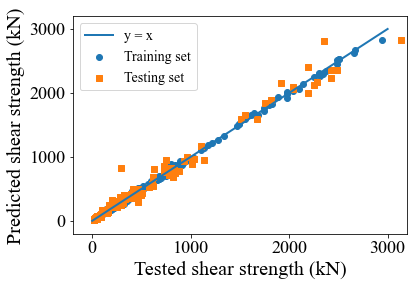

In [12]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

plt.figure()
plt.plot(xx, yy, linewidth=2)
plt.scatter(y_train, Z_1, marker='o')
plt.scatter(y_test, Z_2, marker='s')

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Times New Roman', size = 18)
plt.xticks(fontproperties = 'Times New Roman', size = 18)

font1 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('Tested shear strength (kN)', font1)
plt.ylabel('Predicted shear strength (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])

plt.legend(['y = x','Training set','Testing set'], loc = 'upper left', prop={'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 14,})

plt.savefig('Prediction_xgb.pdf', dpi=600, bbox_inches = 'tight', format='pdf')
plt.show()